In [87]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
import time
from tqdm import tqdm
from IPython import display

In [88]:
#data_dir = 'W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Original Images'
data_dir = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\Original Images- Resize"
image_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.JPG')]
images = []
for img_path in image_paths:
    image = mpimg.imread(img_path)
    images.append(image)
images = (np.array(images) -127.5) / 127.5

In [89]:
images.shape

(53, 384, 576, 3)

In [90]:
BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices(images)
train_dataset = train_dataset.shuffle(32)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [91]:
latent_dim = 100
height = 384
width = 576
channels = 3

In [92]:
# Generator model
generator_inputs = keras.Input(shape = (latent_dim,))

x = layers.Dense(384 * 24 * 36)(generator_inputs)
x = layers.LeakyReLU()(x)
x = layers.Reshape((24, 36, 384))(x)

x = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

generator_outputs = layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh')(x)
generator = keras.Model(generator_inputs, generator_outputs, name='generator')


In [93]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_8 (Dense)             (None, 331776)            33509376  
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 331776)            0         
                                                                 
 reshape_4 (Reshape)         (None, 24, 36, 384)       0         
                                                                 
 conv2d_transpose_20 (Conv2  (None, 48, 72, 512)       786944    
 DTranspose)                                                     
                                                                 
 batch_normalization_16 (Ba  (None, 48, 72, 512)       2048      
 tchNormalization)                                       

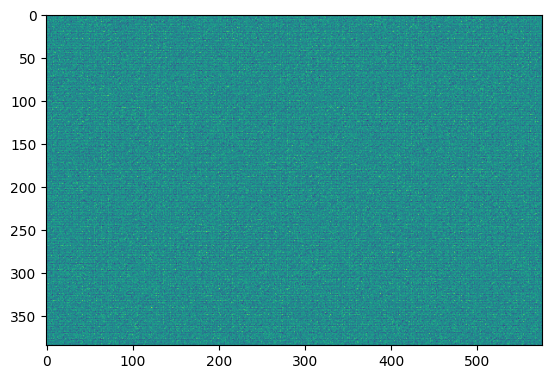

In [94]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training= False)
plt.imshow(generated_image[0, :, :, 0])

In [95]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[height, width, channels]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [96]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 192, 288, 64)      4864      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 192, 288, 64)      0         
                                                                 
 dropout_12 (Dropout)        (None, 192, 288, 64)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 144, 128)      204928    
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 96, 144, 128)      0         
                                                                 
 dropout_13 (Dropout)        (None, 96, 144, 128)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 72, 256)      

In [97]:
print(discriminator(generated_image))

tf.Tensor([[0.49997523]], shape=(1, 1), dtype=float32)


In [98]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [99]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [100]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [101]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [102]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [103]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize=(4,4))

    print(predictions.shape)
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

    plt.show()

In [104]:
model_location = "W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-12_53 images_1000 epochs_Color"

In [105]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        print('Time for epoch {} is {}'.format(epoch+1, time.time() - start))

        if epoch > 150 and (epoch % 50) == 0:
            generator.save(model_location + '/' + str(epoch) + '.h5')

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

(16, 384, 576, 3)


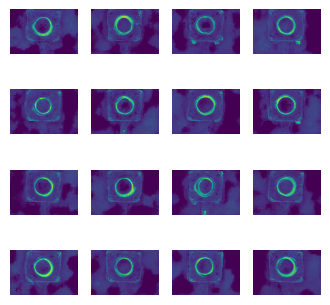

In [106]:
train(train_dataset, EPOCHS)

In [107]:
generator.save('W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-12_53 images_1000 epochs_Color/1000.h5')

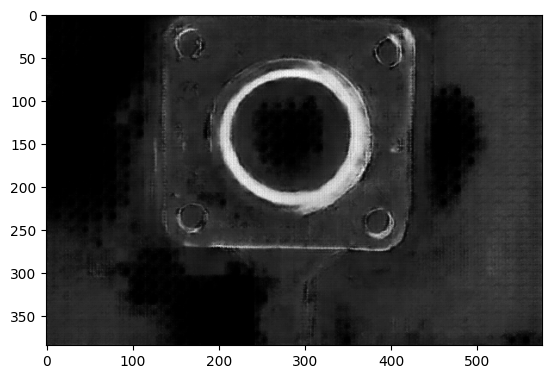

In [111]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
plt.imshow(generator(noise, training=False)[0, :, :, 0], cmap='gray')

In [109]:
from tensorflow.keras.models import load_model

In [110]:
newmodel = load_model('W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models/4000_epoch_31image_model.h5')

OSError: No file or directory found at W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models/4000_epoch_31image_model.h5